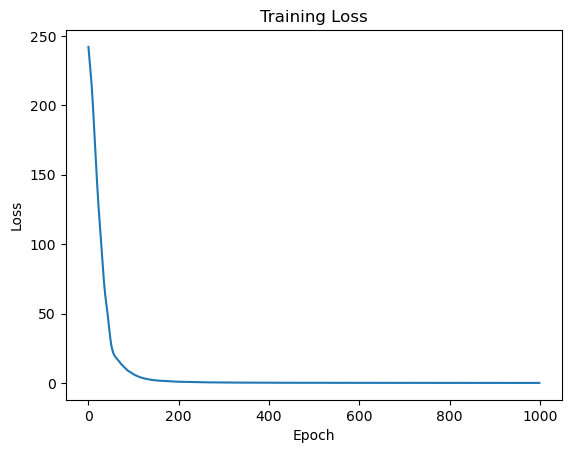

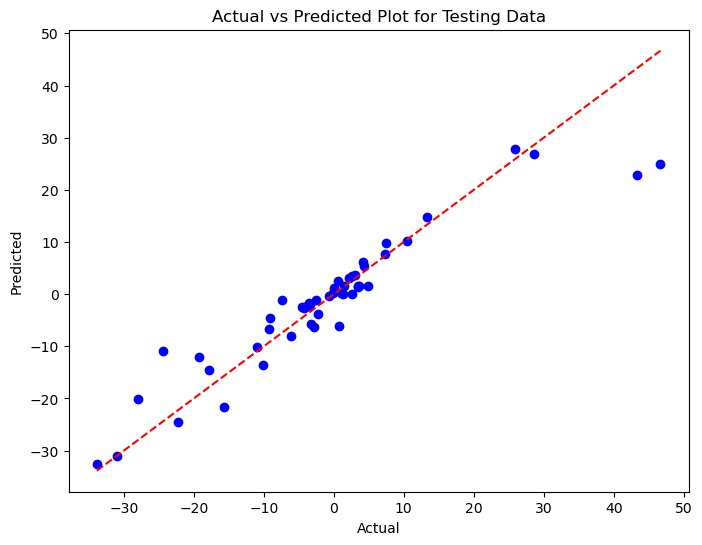

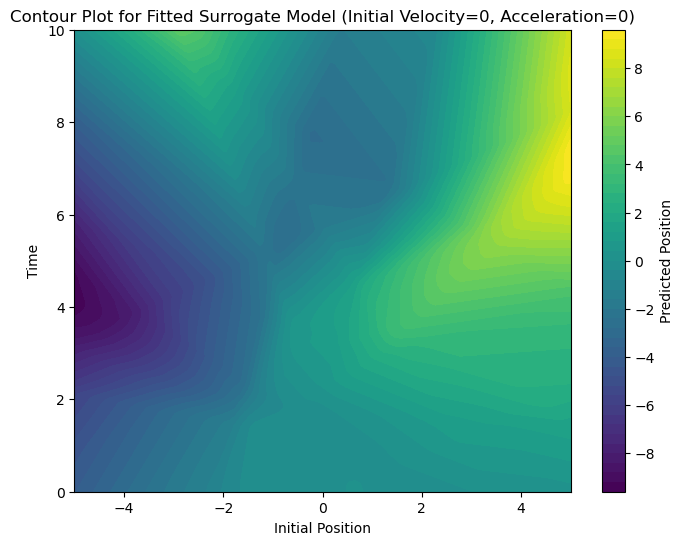

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from pyDOE import lhs

def example_function(input_data):
    initial_position, initial_velocity, acceleration, time = input_data.T
    future_position = initial_position + initial_velocity * time + 0.5 * acceleration * time**2
    return future_position

# Sample size
n = 50

# Generating training and testing input using pyDOE
training_input_lhs = lhs(4, samples=n) * np.array([10, 4, 2, 10]) + np.array([-5, -2, -1, 0])
testing_input_lhs = lhs(4, samples=n) * np.array([10, 4, 2, 10]) + np.array([-5, -2, -1, 0])

# Calculating y values
training_y = example_function(training_input_lhs)
testing_y = example_function(testing_input_lhs)

# PyTorch model
X_train = torch.tensor(training_input_lhs, dtype=torch.float32)
y_train = torch.tensor(training_y, dtype=torch.float32).view(-1, 1)

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.hidden1 = nn.Linear(4, 20)
        self.hidden2 = nn.Linear(20, 20)
        self.output = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

# Neural network instance
neural_network = FeedForwardNN()

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(neural_network.parameters(), lr=0.01)

# Training loop
epochs = 1000
losses = []
for epoch in range(epochs):
    predictions = neural_network(X_train)
    loss = loss_function(predictions, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Plotting the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training Loss')
plt.show()

# Predictions for testing data
testing_predictions = neural_network(torch.tensor(testing_input_lhs, dtype=torch.float32)).detach().numpy()

# Actual vs. Predicted plot for testing data
plt.figure(figsize=(8, 6))
plt.plot(testing_y, testing_predictions, 'bo')
plt.plot([testing_y.min(), testing_y.max()], [testing_y.min(), testing_y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted Plot for Testing Data')
plt.show()

# Contour Plot for specific fixed values
fixed_initial_velocity = 0
fixed_acceleration = 0
x1_range = np.linspace(-5, 5, 100) # initial position
x2_range = np.linspace(0, 10, 100)  # time
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
input_grid = np.c_[x1_grid.ravel(), fixed_initial_velocity * np.ones_like(x1_grid.ravel()), fixed_acceleration * np.ones_like(x1_grid.ravel()), x2_grid.ravel()]
contour_predictions = neural_network(torch.tensor(input_grid, dtype=torch.float32)).detach().numpy()
contour_grid = contour_predictions.reshape(x1_grid.shape)

plt.figure(figsize=(8, 6))
plt.contourf(x1_grid, x2_grid, contour_grid, levels=50, cmap='viridis')
plt.colorbar(label='Predicted Position')
plt.xlabel('Initial Position')
plt.ylabel('Time')
plt.title(f'Contour Plot for Fitted Surrogate Model (Initial Velocity={fixed_initial_velocity}, Acceleration={fixed_acceleration})')
plt.show()
